<a href="https://colab.research.google.com/github/jems2019/MastersProjectWebApp/blob/master/final_project_with_custom_dqn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline
%tensorflow_version 2.x

import random
import gym
from gym import spaces

import json
import datetime as dt
import random 

import numpy as np
import pandas as pd
import collections
from scipy.stats import norm


import matplotlib.pyplot as plt


import tensorflow as tf

from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

print(tf.__version__)
print(tf.test.is_gpu_available())

TensorFlow 2.x selected.
2.0.0
True


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


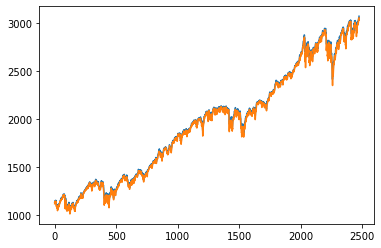

In [0]:
# load data from google drive - this should work for all of us since we all have access to this folder
file_path = '/content/drive/My Drive/Masters project /data/sandp500.csv'
my_df = pd.read_csv(file_path)

plt.plot(my_df['High'])
plt.plot(my_df['Low'])
plt.show()

(6308, 6)


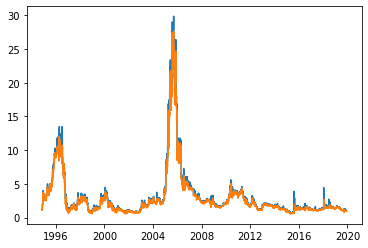

In [0]:
from pandas_datareader.data import DataReader

aapl = DataReader('FORD', 'yahoo', '1990-01-01')

print(aapl.shape)
plt.plot(aapl['High'])
plt.plot(aapl['Low'])
plt.show()

In [0]:
appl.head()

29.850000381469727

## Custom Gym Environment

In [0]:
#df = pd.read_csv('./data/AAPL.csv')
MAX_ACCOUNT_BALANCE = 100000000.0
MAX_NUM_SHARES = 100000000.0

# this should be set by the data lol
MAX_SHARE_PRICE = 5000
# max steps used to decay the reward for early steps in environment
MAX_STEPS = 20000

#start with $100,000
INITIAL_ACCOUNT_BALANCE = 100000

In [0]:
# based off of https://towardsdatascience.com/creating-a-custom-openai-gym-environment-for-stock-trading-be532be3910e
class StockTradingEnv(gym.Env):
    metadata = {'render.modes': ['human']}
    
    def __init__(self, df):
        super(StockTradingEnv, self).__init__()
        # dataframe of stock timeline, the data needed to run the sim
        self.df = df

        # range of possible rewards at each state, used for the environment, never used by user
        self.reward_range = (0, MAX_ACCOUNT_BALANCE)     # Actions of the format Buy x%, Sell x%, Hold, etc.
        # action space is 4 values [buy, sell, hold, % amount]
        # action type is the first 3. first is buy, second is sell, third is hold
        # last item is the percentage of stocks to sell or buy
        # action space low value and high value
        self.action_space = spaces.Box(
            low=np.array([0, 0, 0, 0]), high=np.array([1, 1, 1, 1]), dtype=np.float16)    # Prices contains the OHCL values for the last five prices
        
        # observation space is 2 arrays size 6
        # first array holds stock timeline info, last 5 days of opening, high, low, closing, and volume of stock
        # second array is info of the agent: balance, stocks held, net worth etc.
        self.observation_space = spaces.Box(
            low=0, high=1, shape=(6, 7), dtype=np.float16)
        
        self.reset()
        
    def reset(self):
        # Reset the state of the environment to an initial state
        # set these as the same to start
        self.balance = INITIAL_ACCOUNT_BALANCE # available money to buy stock
        self.net_worth = INITIAL_ACCOUNT_BALANCE # balance + stock equity value
        self.max_net_worth = INITIAL_ACCOUNT_BALANCE # greatest net worth

        #start with no shares 
        self.shares_held = 0
        #cost basis - original value of asset, purchase price adjusted by stock splits, dividends, and return of capital distributions
        self.cost_basis = 0
        self.total_shares_sold = 0
        self.total_sales_value = 0

        # Set the current step to a random point within the data frame to get different 'experiences' per reset
        self.current_step = random.randint(5, len(self.df.loc[:, 'Open'].values)) 
        print('reset on ' + self.df.loc[self.current_step, 'Date'])
        return self.next_observation()


    def monteCarloSimulation(self, days):
        t_intervals = days + 1
        iterations = 100

        # Estimate the historical log returns
        # Using the percent change method to obtain the simple returns from the dataset
        log_returns = np.log(1 + self.df[['Adj Close']].pct_change())

        # mean
        u = log_returns.mean()

        # variance
        var = log_returns.var()

        # compute the drift component
        # it is the best approximation of future rates of return of the stock
        drift = u - (0.5 * var)

        # standard deviation of log returns
        stdev = log_returns.std()

        # getting a randomized multidimensional array that will insert 2 args
        x = np.random.rand(10, 2)

        # include the random element within the ppf distribution to obtain the distance from 
        # the mean corresponding to each of the randomly generated probabilities
        Z = norm.ppf(x)

        # the daily returns will represent the e^r from the Brownian motion
        daily_returns = np.exp(drift.values + stdev.values * norm.ppf(np.random.rand(t_intervals, iterations)))

        # Create price list - the price list will equal the product of the price
        # observed the previous day and the simulated daily return
        # The first stock price used will be the last one from the dataset
        S0 = self.df[['Adj Close']].iloc[-1]

        # initiating price list for the list of prices with the expected stock prices
        price_list = np.zeros_like(daily_returns)

        # setting the entire first row of 10 elements to S0 because that would be the 
        # initial price for each of the 10 iterations we intend to generate
        price_list[0] = S0

        # generate values for the price list
        for t in range(1, t_intervals):
            price_list[t] = price_list[t - 1] * daily_returns[t]

        # looks 'days' amount ahead for simulation
        sim = np.mean(price_list[days])
        return sim

    
    def next_observation(self):

         # Creating simulated stock price estimate for the next day
        self.simulated_closed_value = self.monteCarloSimulation(1)
        # sims for the next 6 days
        monte_carlo_closings = []
        for i in range(1,7):
            monte_carlo_closings.append(self.monteCarloSimulation(i)/MAX_SHARE_PRICE)

        # Get the data points for the current day + last 5 days and scale to between 0-1
        # uses opening values, high values, low values, closing values, and volume per day
        frame = np.array([
            self.df.loc[self.current_step-5: self.current_step,'Open'].values / MAX_SHARE_PRICE,
            self.df.loc[self.current_step-5: self.current_step, 'High'].values / MAX_SHARE_PRICE,
            self.df.loc[self.current_step-5: self.current_step, 'Low'].values / MAX_SHARE_PRICE,
            self.df.loc[self.current_step-5: self.current_step, 'Close'].values / MAX_SHARE_PRICE,
            self.df.loc[self.current_step-5: self.current_step, 'Volume'].values / MAX_NUM_SHARES,
            monte_carlo_closings,
        ])  
        # observation includes past 5 day data, and user's balance and amount of shares hold etc.
        # Append additional data and scale each value to between 0-1
        obs = np.append(frame, [[
            self.balance / MAX_ACCOUNT_BALANCE,
            self.max_net_worth / MAX_ACCOUNT_BALANCE,
            self.shares_held / MAX_NUM_SHARES,
            self.cost_basis / MAX_SHARE_PRICE,
            self.total_shares_sold / MAX_NUM_SHARES,
            self.total_sales_value / (MAX_NUM_SHARES * MAX_SHARE_PRICE),
        ]], axis=0)

        return obs
    

    def take_action(self, action):
        # Set the current price to a random price within the time step
        # this mimics day by day variance
        # current price of the stock 
        current_price = random.uniform(
            self.df.loc[self.current_step, "Open"],
            self.df.loc[self.current_step, "Close"]) 

        # first three parts of action is type of action
        # taking the max between action[0:2] 
        action_type = np.argmax(action[0:2])
        # second part is the amount of stocks to sell/buy in percent (0,1) of possible total stocks you can buy at the time
        # ex. if action[3] = .5 and buying, buy 50% of the possible total stocks you can buy with current balance
        # ex. if action[3] = .5 and selling, sell 50% of your held stocks
        # clip the value to be between [0,1]
        amount = np.clip(action[3], 0, 1)  

        if action_type == 0:
            # Buy amount % of balance in shares
            #total possible amount of shares you can buy
            total_possible = int(self.balance / current_price)
            # number of shares bought in step
            shares_bought = int(total_possible * amount)

            # calculate cost to buy the shares, and buy them by subtracting the cost from your balance
            additional_cost = shares_bought * current_price
            self.balance -= additional_cost
            
            #calculate cost basis  
            prev_cost = self.cost_basis * self.shares_held
            self.cost_basis = (prev_cost + additional_cost) / (self.shares_held + shares_bought)

            # update the number of shares hold
            self.shares_held += shares_bought  

        elif action_type == 1:
            # Sell amount % of shares held
            shares_sold = int(self.shares_held * amount)
            
            # sell shares and add to balance
            self.balance += shares_sold * current_price
            self.shares_held -= shares_sold

            # update some logging variables
            self.total_shares_sold += shares_sold
            self.total_sales_value += shares_sold * current_price  

        # calcuate net worth, which is balance(cash) + shares
        self.net_worth = self.balance + self.shares_held * current_price 

        # update max_net_worth and cost basis
        if self.net_worth > self.max_net_worth:
            self.max_net_worth = self.net_worth  
        if self.shares_held == 0:
            self.cost_basis = 0


    def step(self, action):
        # Execute one time step within the environment
        self.take_action(action)  
        self.current_step += 1  

        # check if there are still possible days in the stock timeline
        # if theere are no more days, reset to the begining of the timeline
        if(self.current_step >= len(self.df.loc[:, 'Open'].values)):
            self.current_step = 5
        
        # delay the reward based on the number of steps taken
        # so early on in timeline, rewards are small  
        # this can probably be changed to something more interesting
        delay_modifier = (self.current_step / MAX_STEPS)

        # check if you have lost more than half your starting money
        done = self.net_worth < INITIAL_ACCOUNT_BALANCE/2

        # reward for current action is the net worth with the delay
        # reward = self.net_worth * delay_modifier
        if not (done): # positive reward if didn't lose money
          reward = 1 + delay_modifier
        else:
          reward = -10

        obs = self.next_observation()  
        return obs, reward, done, {}

            
    def render(self, mode='human', close=False):
        # Render the environment to the screen
        # profit is the total increase of net worth from the start
        profit = self.net_worth - INITIAL_ACCOUNT_BALANCE

        print(f'Step: {self.current_step}')
        print('Date: ' + str( self.df.loc[self.current_step, 'Date']))
        print(f'Balance: {self.balance}')
        print(
            f'Shares held: {self.shares_held} (Total sold: {self.total_shares_sold})')
        print(
            f'Avg cost for held shares: {self.cost_basis} (Total sales value: {self.total_sales_value})')
        print(
            f'Net worth: {self.net_worth} (Max net worth: {self.max_net_worth})')
        print(f'Profit: {profit}')

    def get_profit(self):
        return self.net_worth - INITIAL_ACCOUNT_BALANCE



# Ring Buffer for memory managment 

In [0]:
class RingBuffer:
    """ class that implements a not-yet-full buffer """
    def __init__(self,size_max):
        self.max = size_max
        self.data = []

    class __Full:
        """ class that implements a full buffer """
        def append(self, x):
            """ Append an element overwriting the oldest one. """
            self.data[self.cur] = x
            self.cur = (self.cur+1) % self.max
        def get(self):
            """ return list of elements in correct order """
            return self.data[self.cur:]+self.data[:self.cur]

    def append(self,x):
        """append an element at the end of the buffer"""
        self.data.append(x)
        if len(self.data) == self.max:
            self.cur = 0
            # Permanently change self's class from non-full to full
            self.__class__ = self.__Full

    def get(self):
        """ Return a list of elements from the oldest to the newest. """
        return self.data

# Experience buffer

In [0]:
class ExperienceBuffer:
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)

    def __len__(self):
        return len(self.buffer)

    def append(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        indices = np.random.choice(len(self.buffer), batch_size, replace=False)
        return zip(*[self.buffer[idx] for idx in indices])
        # states, actions, rewards, dones, next_states = zip(*[self.buffer[idx] for idx in indices])
        # return np.array(states), np.array(actions), np.array(rewards, dtype=np.float32), \
        #        np.array(dones, dtype=np.uint8), np.array(next_states)


# DQN Agent

In [0]:
# Deep Q-learning Agent
class DQNAgent:
    def __init__(self, state_size, action_size):
        
        self.state_size = state_size # 6 x 7 - observation space
        self.action_size = action_size # (buy, sell, hold), (percentage for action)
        self.memory = RingBuffer(500) # holds the last 100 days
        self.gamma = 0.95    # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self._build_model()
        self.model = tf.keras.load_model('')

    def _build_model(self):
        # Neural Net for Deep-Q learning Model
        model = Sequential()
        model.add(Dense(24, input_shape=(self.state_size,), activation='relu')) # will change to 42 once we change to 6*7 state size
        model.add(Dense(24, activation='relu'))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(self.action_size)) # (buy, sell, hold), (percentage for action)
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))

        model.summary()

        return model

    # puts into memory
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    # choose random action based on epsilon
    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.rand(1, self.action_size)
        act_values = self.model.predict(state)
        return act_values  # returns action
        
    # learn function - train
    def replay(self, batch_size):
        # batch size sample from memory
        # ex: if batch size is 32, it would take 32 random days from the 1000 memory that we have
        minibatch = random.sample(self.memory.get(), batch_size) 
        # minibatch = self.memory.sample(batch_size)
        # state, action, reward, next_state, done = minibatch
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                # Bellman equation
                # np.amax(self.model.predict(next_state.flatten().reshape(1,self.state_size))[0][0:2]) - next action
                target = reward + self.gamma * np.amax(self.model.predict(next_state.flatten().reshape(1,self.state_size))[0])
            
            # action space to fit NN
            target_f = self.model.predict(state.flatten().reshape(1,self.state_size))
            # what action that was taken
            p_action = np.argmax(action[0:3])
            # replace action that you take with the target value
            target_f[0][p_action] = target
            self.model.fit(state.flatten().reshape(1,self.state_size), target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay




# Build Environments and Agent

In [0]:
env = StockTradingEnv(my_df)

print(env.observation_space.shape)
print(env.action_space.shape)
env.reset()

tf.keras.backend.clear_session()
agent = DQNAgent(42, 4)

action = agent.act(env.next_observation().reshape(1,42))
print(action)

obs, reward, done, _ = env.step(action[0])

print(obs)
print(reward)
#print(env.next_observation().flatten().reshape(1,36))

reset on 2018-12-13
(6, 7)
(4,)
reset on 2012-08-13
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 24)                1032      
_________________________________________________________________
dense_1 (Dense)              (None, 24)                600       
_________________________________________________________________
dense_2 (Dense)              (None, 24)                600       
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 100       
Total params: 2,332
Trainable params: 2,332
Non-trainable params: 0
_________________________________________________________________
[[0.45020493 0.96176996 0.33737666 0.11232573]]
[[2.78891992e-01 2.80245996e-01 2.80452002e-01 2.80515991e-01
  2.81173999e-01 2.80871997e-01]
 [2.81428003e-01 2.80828003e-01 2.81189990e-01 2.81195996

# Train Agent

In [0]:
# Iterate the stock trading
episodes = 100

for e in range(episodes):
    # reset state in the beginning of each game
    state = env.reset()
    # time_t represents each frame of the game
    # Our goal is to keep the pole upright as long as possible until score of 500
    # the more time_t the more score
    # Runs through ~2 years per episode 
    for time_t in range(500):
        # turn this on if you want to render
        # env.render()
        # Decide action
        action = agent.act(state.flatten().reshape(1,42))
        next_state, reward, done, _ = env.step(action[0])
        # Remember the previous state, action, reward, and done
        agent.remember(state, action, reward, next_state, done)
        # make next_state the new current state for the next frame.
        state = next_state
        # done becomes True when the game ends
        # ex) The agent drops the pole
        if done:
            # print the score and break out of the loop
            print("episode: {}/{}, score: {}".format(e, episodes, time_t))
            break
    # train the agent with the experience of the episode
    agent.replay(32)

    if (e % 10 == 0):
        print('episode ' + str(e))

    #env.render()

print('done')

reset on 2014-01-27
episode 0
reset on 2015-04-09
reset on 2012-03-26
reset on 2015-10-08
reset on 2011-06-22
reset on 2015-01-13
reset on 2010-10-12
reset on 2016-01-12
reset on 2014-01-21
reset on 2011-06-14
reset on 2014-12-10
episode 10
reset on 2014-02-05
reset on 2012-10-11
reset on 2012-05-11
reset on 2018-10-26


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:161: RuntimeWarning: invalid value encountered in double_scalars


reset on 2015-02-24
reset on 2014-08-13
reset on 2015-06-12
reset on 2018-01-05
reset on 2015-06-19
reset on 2011-09-21
episode 20
reset on 2013-01-24
reset on 2016-08-03
reset on 2012-09-13
reset on 2013-03-06
reset on 2014-04-28
reset on 2012-09-18
reset on 2019-08-30
reset on 2015-09-11
reset on 2010-06-21
reset on 2019-01-22
episode 30
reset on 2011-02-08
reset on 2017-12-14
reset on 2015-10-01
reset on 2013-07-22
reset on 2016-06-30
reset on 2011-03-02
reset on 2012-10-26
reset on 2017-07-13
reset on 2017-02-21
reset on 2018-05-01
episode: 40/100, score: 381
episode 40
reset on 2019-10-09
reset on 2017-07-20
reset on 2011-01-03
reset on 2013-04-26
reset on 2010-11-24
reset on 2010-03-05
reset on 2015-10-30
reset on 2017-09-14
reset on 2016-06-01
reset on 2015-05-21
episode 50
reset on 2012-09-21
reset on 2017-07-11
reset on 2017-02-28
reset on 2011-12-07
reset on 2013-07-30
reset on 2011-08-02
reset on 2017-11-08
reset on 2010-06-02
reset on 2014-05-20
reset on 2013-01-14
episode 

# Run it for one year

In [0]:
state = env.reset()
env.render()
# time_t represents each frame of the game
# Our goal is to keep the pole upright as long as possible until score of 500
# the more time_t the more score
# Runs through 1 year per episode 
for time_t in range(260):
    # turn this on if you want to render
    # env.render()
    # Decide action
    action = agent.act(state.flatten().reshape(1,42))
    next_state, reward, done, _ = env.step(action[0])
    # Remember the previous state, action, reward, and done
    agent.remember(state, action, reward, next_state, done)
    # make next_state the new current state for the next frame.
    state = next_state
    # done becomes True when the game ends
    if done:
        # print the score and break out of the loop
        print("episode: {}/{}, score: {}".format(e, episodes, time_t))
        break

print('\n\nAfter 1 year of trading')
env.render()

reset on 2017-09-08
Step: 1934
Date: 2017-09-08
Balance: 100000
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0)
Net worth: 100000 (Max net worth: 100000)
Profit: 0


After 1 year of trading
Step: 2194
Date: 2018-09-20
Balance: 6761.313856654688
Shares held: 37 (Total sold: 1167)
Avg cost for held shares: 2878.4510316014903 (Total sales value: 3156633.654356267)
Net worth: 114352.66846155928 (Max net worth: 114352.66846155928)
Profit: 14352.668461559282


In [0]:
agent.model.save('/content/drive/My Drive/Masters project /data/100e_model.h5')